In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from palette import REGULATION_PAL_D
from src.plotter import savefig

In [ ]:
df_aged = pd.read_excel('resources/Markers-Aged-Group.xlsx')
df_mid = pd.read_csv('resources/Markers-Mid-Age-Group.csv', index_col=0)

In [131]:
senset = np.array(open("resources/SenSet.txt").read().splitlines())

In [128]:
mid_markers = set()
for s in np.concatenate(df_mid[['Up_set', 'Down_set']].to_numpy()):
    mid_markers |= s
mid_markers = np.sort(np.array(list(mid_markers)))

In [138]:
senset.shape, mid_markers.shape, np.intersect1d(senset, mid_markers).size

((106,), (139,), 90)

In [ ]:
# normalize columns
df_aged = df_aged.rename(columns={'Upregulated':'Up','Downregulated':'Down'})

def parse_genes(x):
    if pd.isna(x): return set()
    return {g.strip() for g in x.split(',') if g.strip()}

for df in (df_mid, df_aged):
    df['Up_set']   = df['Up'].apply(parse_genes)
    df['Down_set'] = df['Down'].apply(parse_genes)

# compute metrics
records = []
cell_types = sorted(set(df_mid['Cell Type']) & set(df_aged['Cell Type']))

for ct in cell_types:
    mid_row  = df_mid[df_mid['Cell Type']==ct].iloc[0]
    aged_row = df_aged[df_aged['Cell Type']==ct].iloc[0]
    for direction in ('Up','Down'):
        A = mid_row[f'{direction}_set']
        B = aged_row[f'{direction}_set']
        inter = A & B
        union = A | B

        records.append({
            'Cell Type':    ct,
            'Direction':     direction,
            '#Mid genes':   len(A),
            '#Aged genes':  len(B),
            '#Shared':      len(inter),
            'Jaccard':      (len(inter) / len(union) if union else np.nan),
            '%Mid→Aged':    (len(inter) / len(A)*100 if A else np.nan),
        })

summary = pd.DataFrame(records)

# add a "min‐count" column and filter out tiny sets (e.g. <5 genes)
min_threshold = 5
summary['Min_genes'] = summary[['#Mid genes','#Aged genes']].min(axis=1)
filtered = summary[summary['Min_genes'] >= min_threshold]

print("\nFiltered summary (min genes >= {})".format(min_threshold))
filtered


Filtered summary (min genes >= 5)


,Cell Type,Direction,#Mid genes,#Aged genes,#Shared,Jaccard,%Mid→Aged,Min_genes
0,CD1c-positive myeloid dendritic cell,Up,31,12,10,0.303030,32.258065,12
2,"CD4-positive, alpha-beta T cell",Up,18,47,16,0.326531,88.888889,18
4,acinar cell,Up,97,28,21,0.201923,21.649485,28
5,acinar cell,Down,6,11,3,0.214286,50.000000,6
6,alveolar macrophage,Up,110,87,61,0.448529,55.454545,87
7,alveolar macrophage,Down,12,9,3,0.166667,25.000000,9
10,capillary endothelial cell,Up,33,48,20,0.327869,60.606061,33
12,elicited macrophage,Up,24,34,17,0.414634,70.833333,24
13,elicited macrophage,Down,75,28,22,0.271605,29.333333,28
16,lung macrophage,Up,5,9,5,0.555556,100.000000,5


/var/folders/b_/1w737bbn611fq7bhjvy_zm240000gn/T/ipykernel_60021/3564948003.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(cell_types, rotation=90, ha='center', size=12)


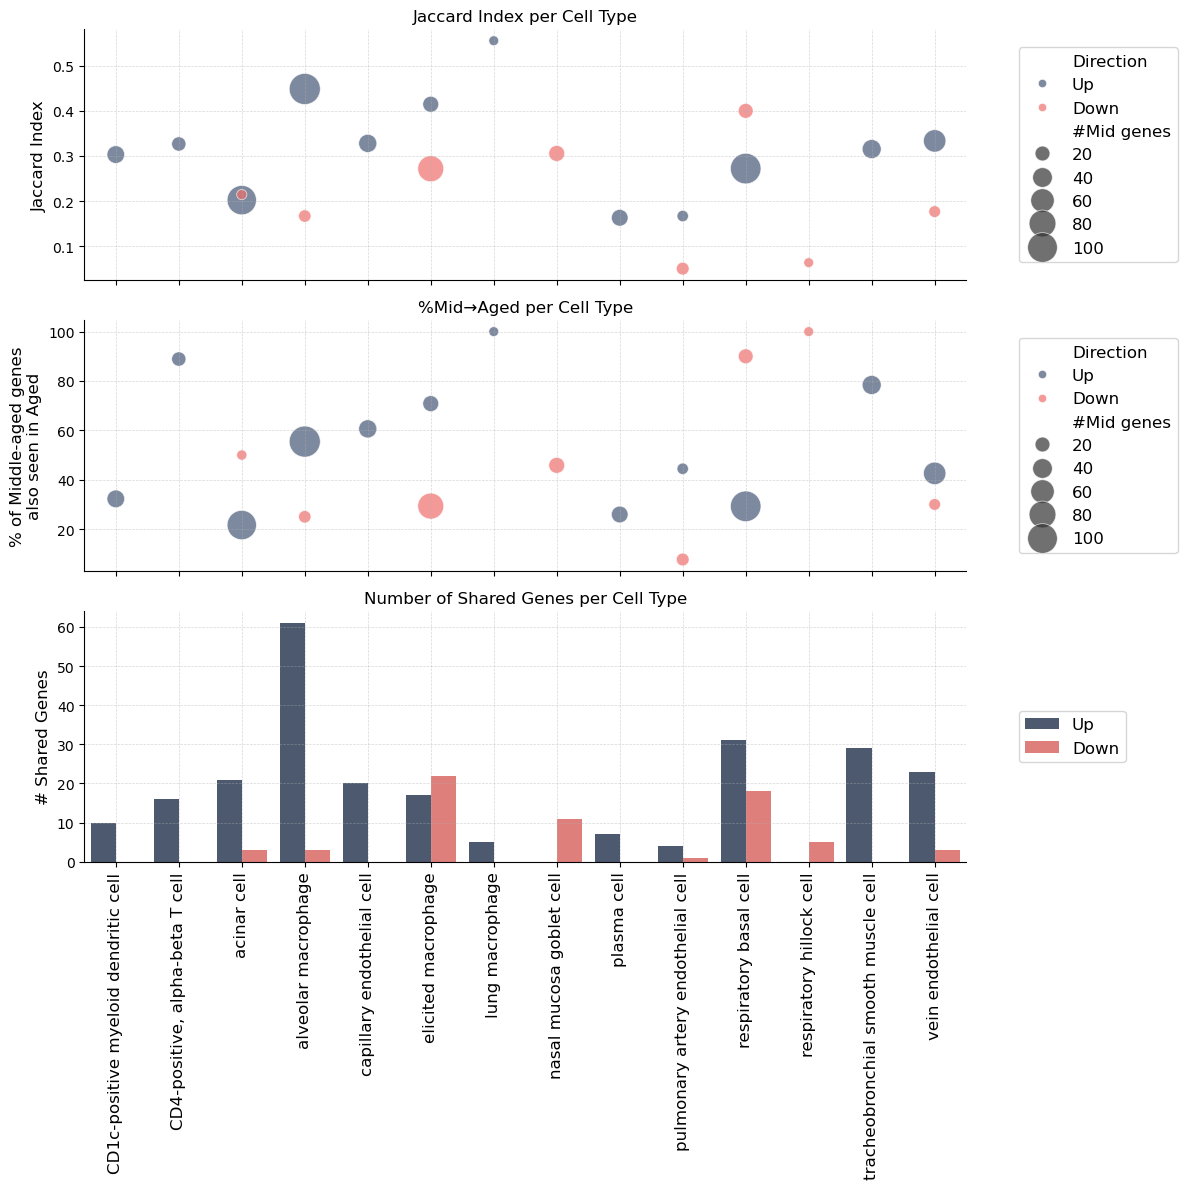

In [139]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# assumed: `filtered`, `cell_types`, and `directions = ['Up','Down']` are defined

custom_palette = {'Up':'#1f77b4','Down':'#ff7f0e'}

fig, axes = plt.subplots(3, 1, sharex=True, figsize=(12, 12))

# Panel 1: Jaccard bubble chart
sns.scatterplot(
    data=filtered,
    x='Cell Type', y='Jaccard',
    size='#Mid genes', sizes=(50,500),
    hue='Direction', palette=REGULATION_PAL_D,
    alpha=0.7, ax=axes[0]
)
axes[0].set_ylabel('Jaccard Index', fontsize=12)
axes[0].set_title('Jaccard Index per Cell Type', fontsize=12)
axes[0].legend(title='', loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=12)
axes[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

# Panel 2: %Mid→Aged bubble chart
sns.scatterplot(
    data=filtered,
    x='Cell Type', y='%Mid→Aged',
    size='#Mid genes', sizes=(50,500),
    hue='Direction', palette=REGULATION_PAL_D,
    alpha=0.7, ax=axes[1]
)
axes[1].set_ylabel('% of Middle-aged genes\nalso seen in Aged', fontsize=12)
axes[1].set_title('%Mid→Aged per Cell Type', fontsize=12)
axes[1].legend(title='', loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=12)
axes[1].grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

# Panel 3: Absolute shared counts barplot
sns.barplot(
    data=filtered,
    x='Cell Type', y='#Shared',
    hue='Direction', palette=REGULATION_PAL_D,
    ax=axes[2]
)
axes[2].set_ylabel('# Shared Genes', fontsize=12)
axes[2].set_title('Number of Shared Genes per Cell Type', fontsize=12)
axes[2].set_xticklabels(cell_types, rotation=90, ha='center', size=12)
axes[2].legend(title='', loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=12)
axes[2].grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

# Common x‐label
axes[2].set_xlabel('')

sns.despine()
plt.tight_layout()
savefig("figures/Supplement/Middle-Aged.pdf")
plt.show()